<a href="https://colab.research.google.com/github/fantaxiah/Dissertation/blob/main/OleidODmeasurement12123Kiara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Assuming you have a DataFrame 'df' with columns 'pH' and 'absorption'
# Replace 'your_data.csv' with the actual file or data source

# Read your data into a DataFrame
df = pd.read_csv('/content/OleicODmeasurment12123Kiara.csv')

# Find the maximum value in the 'absorption' column
max_absorption = df['absorption'].max()

# Perform Min-Max normalization on the 'absorption' column
df['normalized_absorption'] = df['absorption'] / max_absorption

# Display the DataFrame with normalized 'absorption'
print(df[['pH', 'normalized_absorption']])

       pH  normalized_absorption
0   12.01               0.199878
1   12.01               0.187728
2   12.01               0.199878
3   11.02               0.188943
4   11.02               0.194411
5   11.02               0.196233
6   10.03               0.191373
7   10.03               0.199878
8   10.03               0.157959
9    9.14               0.275213
10   9.14               0.259417
11   9.14               0.269745
12   8.78               0.286756
13   8.78               0.305589
14   8.78               0.313487
15   8.60               0.512758
16   8.60               0.342649
17   8.60               0.308627
18   8.34               0.315917
19   8.34               0.346294
20   8.34               0.343256
21   8.23               0.317740
22   8.23               0.356622
23   8.23               0.357837
24   7.97               0.339611
25   7.97               0.367558
26   7.97               0.404617
27   7.80               0.406440
28   7.80               0.366950
29   7.80 

In [3]:
# Filter out data with pH values less than 6
df_filt = df[df['pH'] > 6]

# Calculate standard deviation
std_dev = df_filt['normalized_absorption'].std()

print(df_filt)

       pH  absorption  normalized_absorption
0   12.01       0.329               0.199878
1   12.01       0.309               0.187728
2   12.01       0.329               0.199878
3   11.02       0.311               0.188943
4   11.02       0.320               0.194411
5   11.02       0.323               0.196233
6   10.03       0.315               0.191373
7   10.03       0.329               0.199878
8   10.03       0.260               0.157959
9    9.14       0.453               0.275213
10   9.14       0.427               0.259417
11   9.14       0.444               0.269745
12   8.78       0.472               0.286756
13   8.78       0.503               0.305589
14   8.78       0.516               0.313487
15   8.60       0.844               0.512758
16   8.60       0.564               0.342649
17   8.60       0.508               0.308627
18   8.34       0.520               0.315917
19   8.34       0.570               0.346294
20   8.34       0.565               0.343256
21   8.23 

In [4]:
# Sigmoid function from Sean's paper
def sigmoid(x, a, b, c):
    return a / (1 + np.exp((a * x) + b))

# Fit sigmoid curve
# Initial guesses for parameters a, b, and c
# initial_guesses = [1, 0, 0]
initial_guess = [max(df_filt['normalized_absorption']), 1, np.median(df_filt['pH'])]

# Fit sigmoid curve to the normalized absorption data
params, covariance = curve_fit(sigmoid, df_filt['pH'], df_filt['normalized_absorption'], p0=initial_guess, maxfev=20000, method='trf')

In [5]:
# Number of bootstrap samples
num_samples = 2000
bootstrap_params = np.zeros((num_samples, len(params)))

for i in range(num_samples):
    indices = np.random.choice(len(df_filt['pH']), len(df_filt['pH']), replace=True)
    x_bootstrap = df_filt['pH'].iloc[indices]
    y_bootstrap = df_filt['normalized_absorption'].iloc[indices]
    bootstrap_params[i, :], _ = curve_fit(sigmoid, x_bootstrap, y_bootstrap)

confidence_interval = np.percentile(bootstrap_params, [15, 85], axis=0)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Generate a finer set of x-values for the plot
fine_pH_values = np.linspace(df_filt['pH'].min(), df_filt['pH'].max(), 1000)

# Predicted values using the fitted parameters for the finer set of x-values
fine_sigmoid_fit = sigmoid(fine_pH_values, *params)

# Create a new DataFrame with the fine_pH_values and corresponding fine_sigmoid_fit
df_fine = pd.DataFrame({'pH': fine_pH_values, 'sigmoid_fit': fine_sigmoid_fit})

# Round the 'pH' values in both DataFrames
df_filt.loc[:, 'pH_rounded'] = df_filt['pH'].round(5).astype(float)
df_fine.loc[:, 'pH_rounded'] = df_fine['pH'].round(5).astype(float)

# Merge the new DataFrame with the original DataFrame on the 'pH' column
df_merged = pd.merge(df_filt, df_fine, on='pH_rounded', how='left')

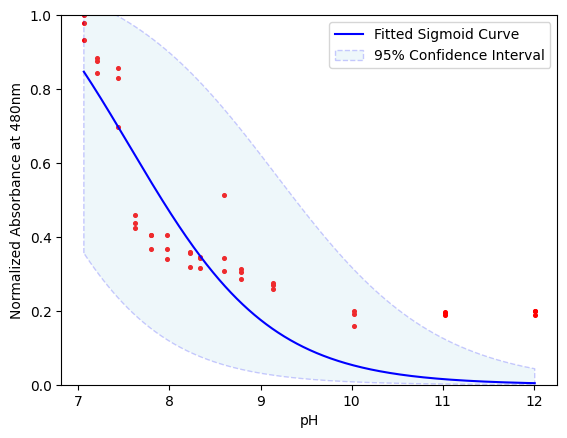

In [7]:
# Plot the filtered data and the fitted sigmoid curve with higher resolution
plt.scatter(df_filt['pH'], df_filt['normalized_absorption'], s=7, color='red')
plt.plot(fine_pH_values, fine_sigmoid_fit, label='Fitted Sigmoid Curve', color='blue')

# Add a shaded area for the 95% confidence interval
plt.fill_between(fine_pH_values, sigmoid(fine_pH_values, *confidence_interval[0]), sigmoid(fine_pH_values, *confidence_interval[1]), color='lightblue', linestyle='dashed', linewidth=1, edgecolor='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('pH')
plt.ylabel('Normalized Absorbance at 480nm')

# Set y-axis limits to be no greater than 1
plt.ylim(0, 1)

plt.legend()
plt.show()